# SimGNN Approximation of Graph Edit Distance (GED)

This notebook demonstrates how to:
1. Load a real dataset (e.g., MUTAG)
2. Generate a synthetic GED dataset via controlled perturbations
3. Visualize original vs perturbed graphs
4. Train a SimGNN model to approximate the normalized GED
5. Evaluate the trained model quantitatively and visually


In [1]:
import sys, os
# Add the repo root (one level up from src/) to Python's path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import torch
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from torch_geometric.utils import to_networkx

from src.datasets.mutag import load_mutag
from src.datasets.proteins import load_protein
from src.datasets.ged_dataset import create_and_save_ged_dataset, GEDDataset, collate_pairs
from src.datasets.graph_perturb import plot_graph_pair
from src.models.sim_gnn import SimGNN
from src.trainers.train_sim_gnn import train_epoch, evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
graphs = load_protein()
print(f"Loaded {len(graphs)} graphs from MUTAG.")
print(graphs[0])

Loaded 1113 graphs from MUTAG.
Data(edge_index=[2, 162], x=[42, 3], y=[1])


In [3]:
os.makedirs("data", exist_ok=True)
ged_path = "data/mutag_ged.pt"

ged_dataset = create_and_save_ged_dataset(
    graphs,
    out_path=ged_path,
    n_perturbations=5,
    node_add_prob=0.5,
    node_remove_prob=0.5,
    edge_add_prob=0.1,
    edge_remove_prob=0.1,
    sample_mode="beta"
)

print(f"Created GED dataset with {len(ged_dataset)} pairs.")

Generating synthetic GED dataset with 5 perturbations per graph...
Saved GED dataset (raw + normalized) to data/mutag_ged.pt (5565 pairs)
Created GED dataset with 5565 pairs.


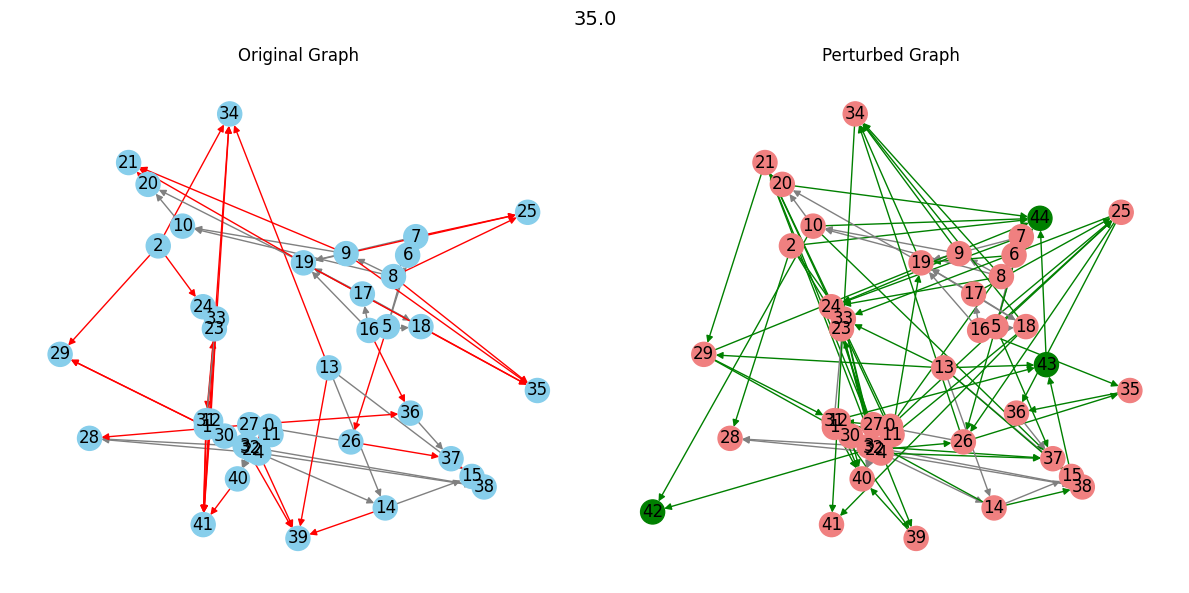

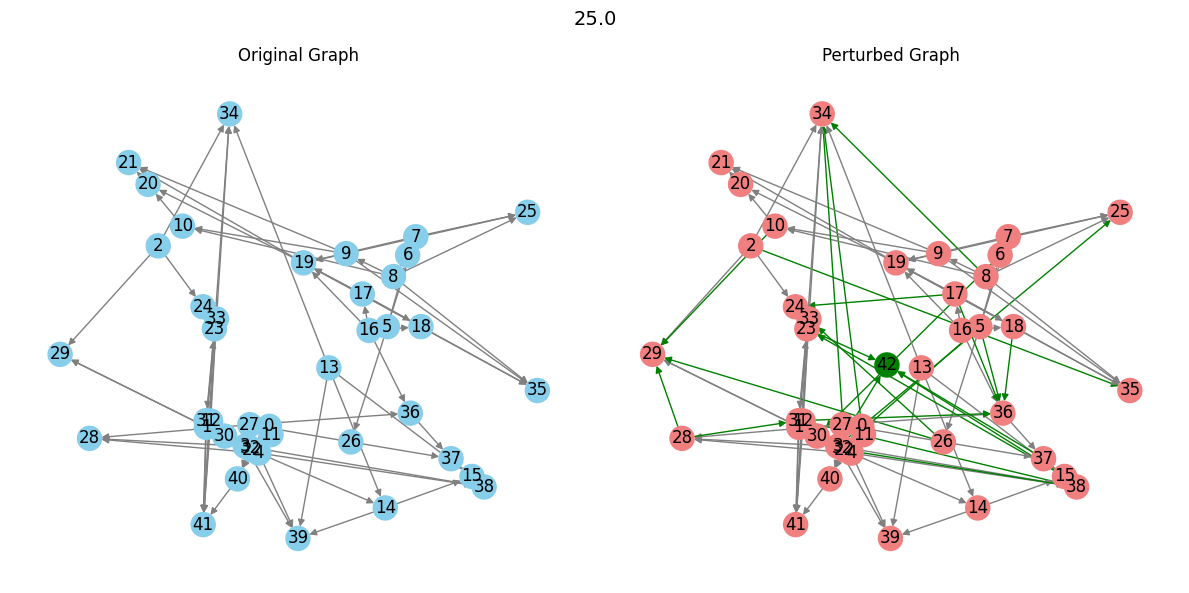

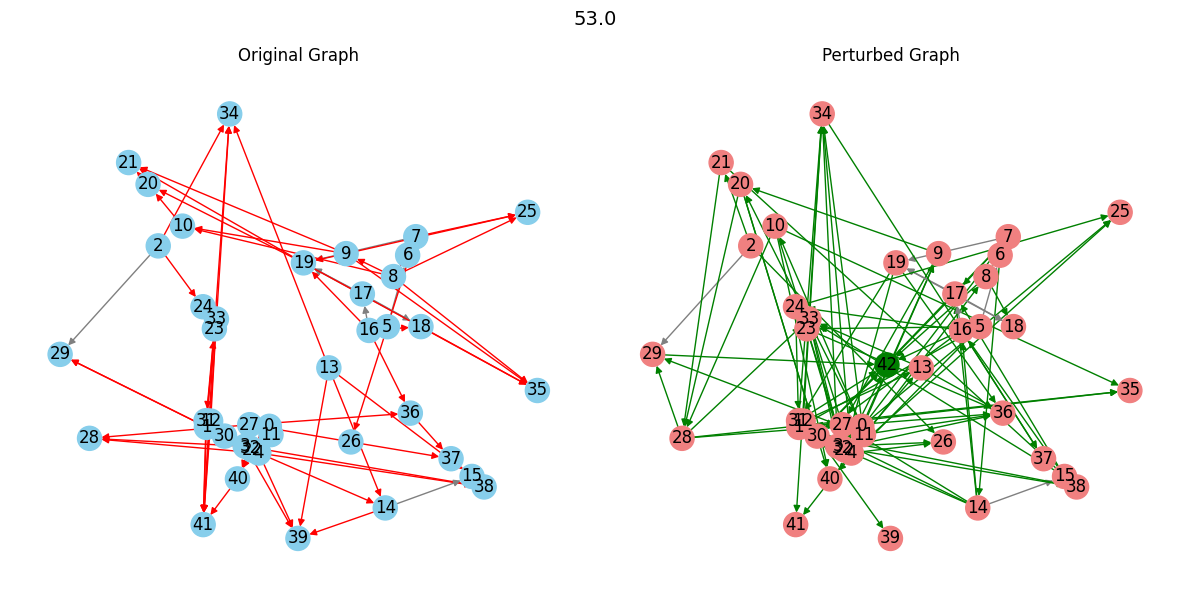

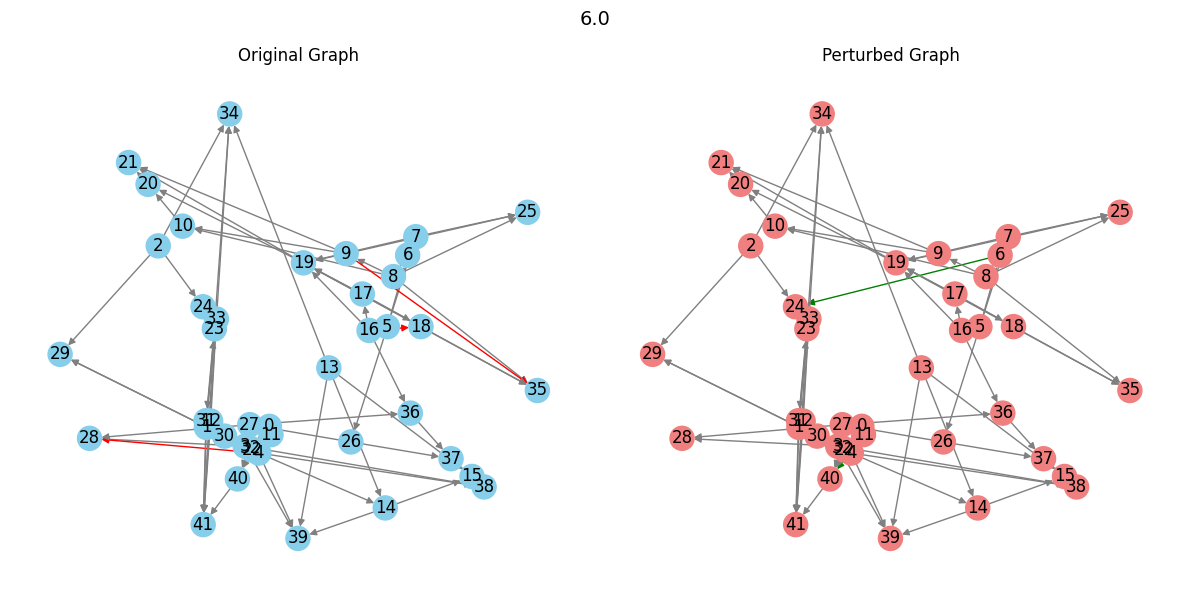

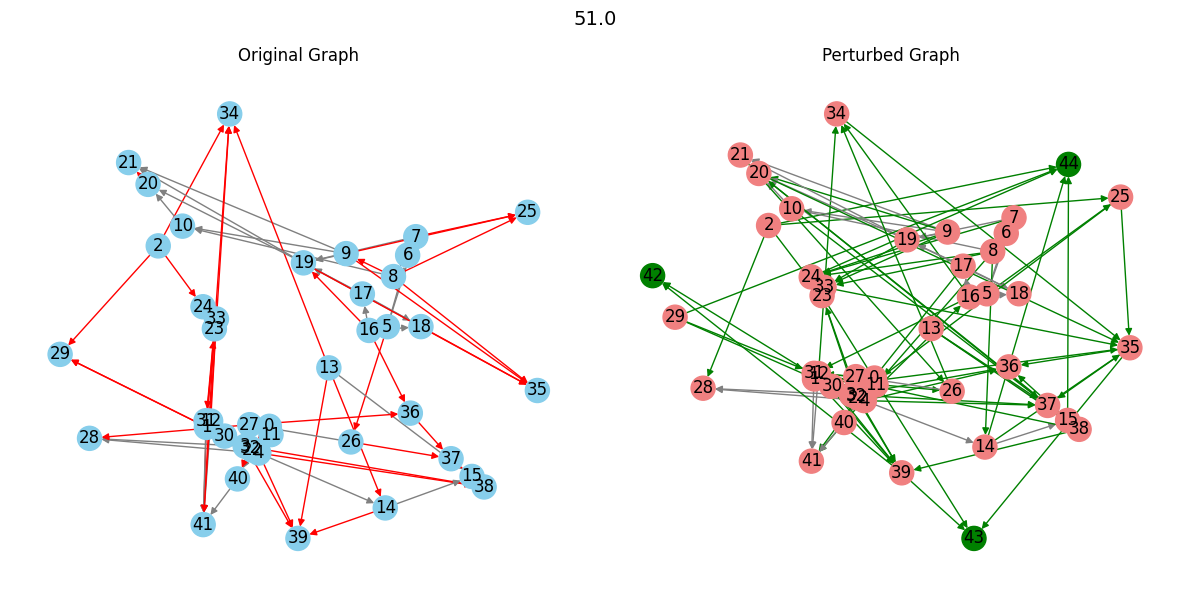

In [4]:
for i in range(5):
    g1, g2, ged_norm = ged_dataset[i]
    raw_ged = getattr(g1, "raw_ged", ged_norm)
    plot_graph_pair(g1, g2, label=raw_ged)

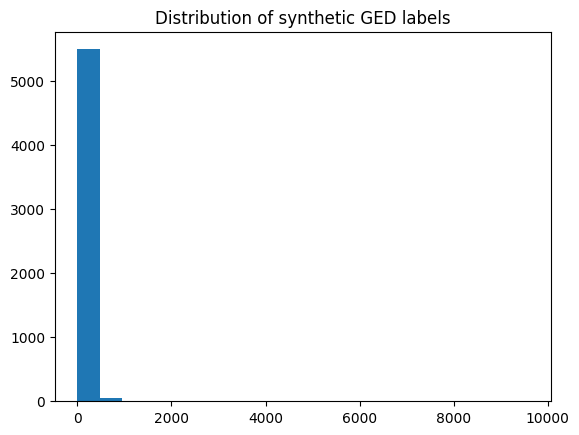

In [5]:
ged_values = [g1.raw_ged for g1, _, _ in ged_dataset]
plt.hist(ged_values, bins=20)
plt.title("Distribution of synthetic GED labels")
plt.show()

In [6]:
dataset = GEDDataset.load(ged_path)
loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_pairs)

in_dim = dataset[0][0].x.size(1)
print(f"Input feature dimension: {in_dim}")

model = SimGNN(in_dim, hidden_dim=32, use_tensor=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

/repo/new-dist/src/datasets/ged_dataset.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pairs: List[Tuple[Data, Data, Dict[str, float]]] = torch.load(path)


Input feature dimension: 3
SimGNN(
  (encoder): GINEncoder(
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv2): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (tensor): TensorNetworkModule(
    (fc): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=72, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [7]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss_norm, loss_raw = train_epoch(model, loader, optimizer, device)
    if epoch % 5 == 0:
        metrics = evaluate(model, loader, device, verbose=False)
        print(f"Epoch {epoch:03d}: {metrics}")


Epoch 005: {'mae_norm': 0.16934603452682495, 'mse_norm': 0.04587418958544731, 'corr_norm': 0.8434750661602873, 'mae_raw': 10.404302597045898, 'mse_raw': 509.68426513671875, 'corr_raw': 0.9465796376102267}
Epoch 010: {'mae_norm': 0.15797089040279388, 'mse_norm': 0.04169858992099762, 'corr_norm': 0.8570322846335127, 'mae_raw': 9.898885726928711, 'mse_raw': 640.1690063476562, 'corr_raw': 0.9069817527985679}
Epoch 015: {'mae_norm': 0.15151703357696533, 'mse_norm': 0.04163012281060219, 'corr_norm': 0.8683417546611376, 'mae_raw': 9.914258003234863, 'mse_raw': 1050.48046875, 'corr_raw': 0.9459507099880416}
Epoch 020: {'mae_norm': 0.14270395040512085, 'mse_norm': 0.034524042159318924, 'corr_norm': 0.8847487961835591, 'mae_raw': 9.341586112976074, 'mse_raw': 706.5664672851562, 'corr_raw': 0.9208461933015816}
Epoch 025: {'mae_norm': 0.14899738132953644, 'mse_norm': 0.039347875863313675, 'corr_norm': 0.879049687647938, 'mae_raw': 9.140012741088867, 'mse_raw': 476.7396240234375, 'corr_raw': 0.9623

In [8]:
# Evaluate trained model
metrics = evaluate(model, loader, device, verbose=True)
print("Final training metrics:", metrics)


[Eval] MAE(norm)=0.1319, MSE(norm)=0.0280, Corr(norm)=0.922 | MAE(raw)=8.3386, MSE(raw)=783.9091, Corr(raw)=0.977
Final training metrics: {'mae_norm': 0.13193511962890625, 'mse_norm': 0.027989087626338005, 'corr_norm': 0.9219202910554467, 'mae_raw': 8.338573455810547, 'mse_raw': 783.9090576171875, 'corr_raw': 0.9767372033713235}


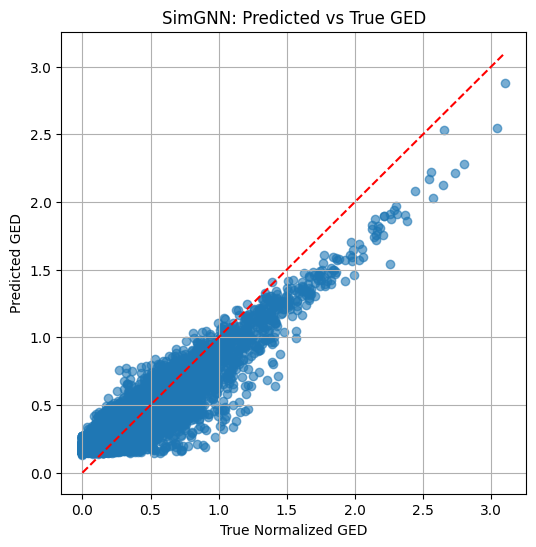

In [9]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch1, batch2, lbl in loader:
        batch1, batch2, lbl = batch1.to(device), batch2.to(device), lbl.to(device)
        pred = model(batch1, batch2)
        all_preds.append(pred.cpu())
        all_labels.append(lbl.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

plt.figure(figsize=(6,6))
plt.scatter(all_labels, all_preds, alpha=0.6)
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--')
plt.xlabel("True Normalized GED")
plt.ylabel("Predicted GED")
plt.title("SimGNN: Predicted vs True GED")
plt.grid(True)
plt.show()


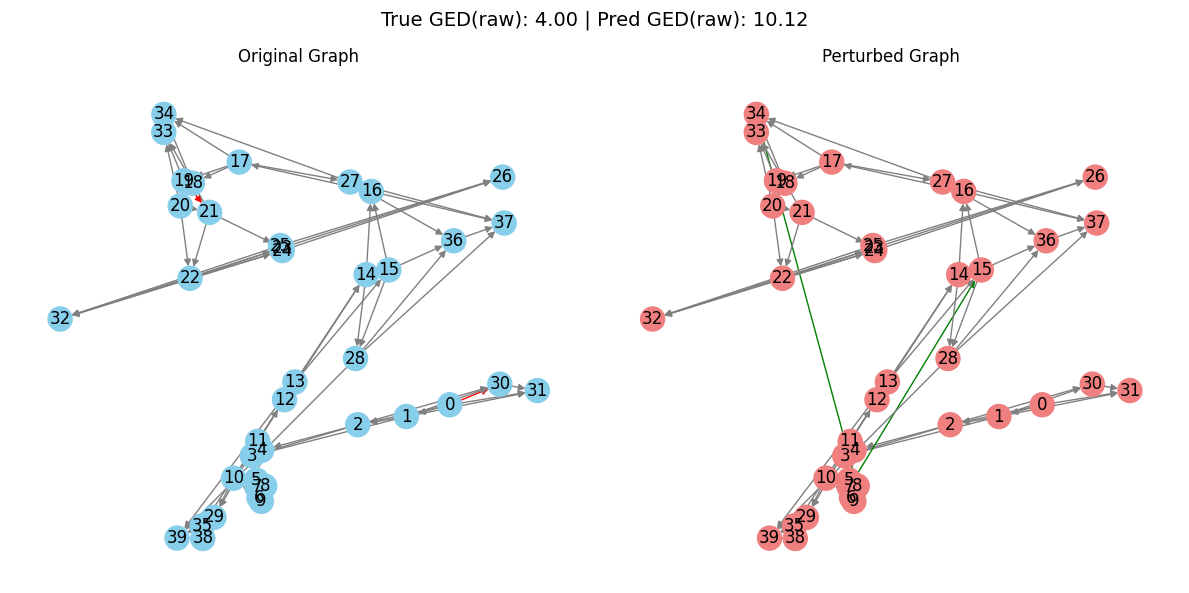

Index 1113
  True GED (raw): 4.000
  Pred GED (raw): 10.117
  GED (norm): 0.0630
  Pred GED (norm): 0.1593
------------------------------------------------------------


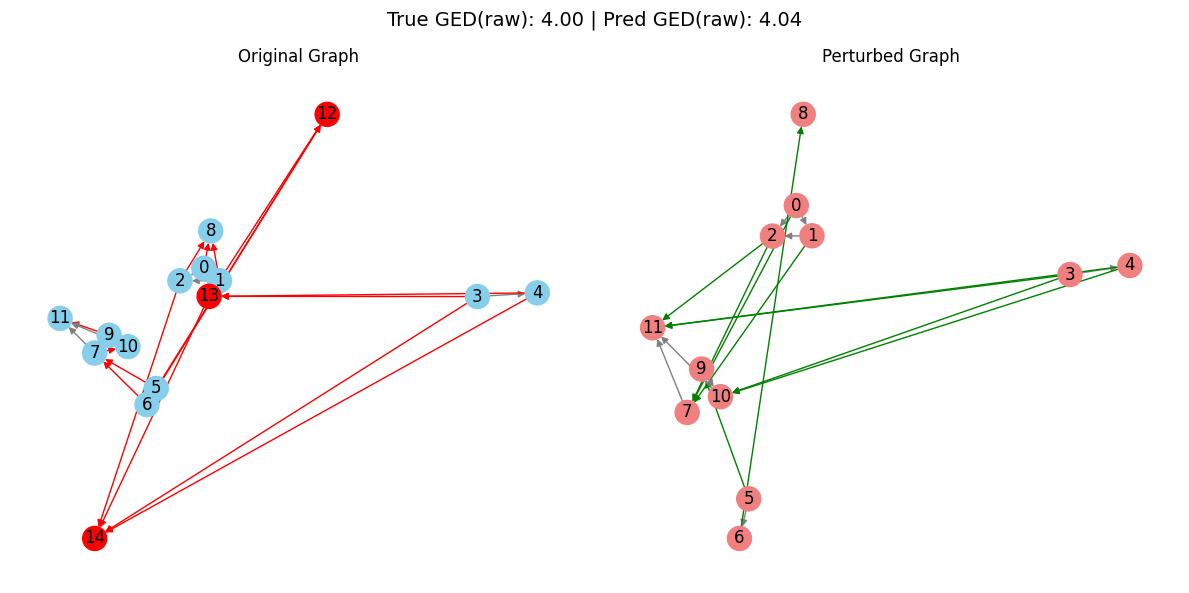

Index 1860
  True GED (raw): 4.000
  Pred GED (raw): 4.037
  GED (norm): 0.2286
  Pred GED (norm): 0.2307
------------------------------------------------------------


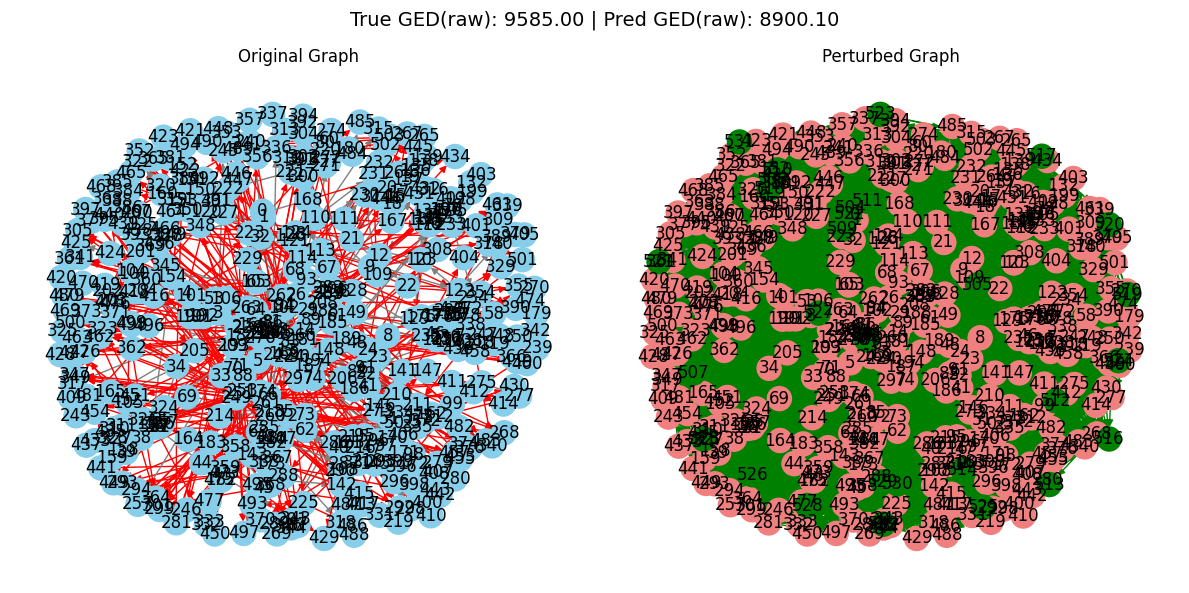

Index 1222
  True GED (raw): 9585.000
  Pred GED (raw): 8900.099
  GED (norm): 3.1032
  Pred GED (norm): 2.8815
------------------------------------------------------------


In [12]:
import torch
import random
from src.datasets.graph_perturb import plot_graph_pair

model.eval()
with torch.no_grad():
    for idx in random.sample(range(len(ged_dataset)), 3):
        # Load graphs and ground-truth values
        g1, g2, ged_norm = ged_dataset[idx]
        raw_ged_true = ged_dataset.get_raw_ged(idx)
        norm_factor = ged_dataset.get_norm_factor(idx)

        # Move graphs to device and predict normalized GED
        batch1 = g1.to(device)
        batch2 = g2.to(device)
        pred_norm = model(batch1, batch2).cpu().item()

        # Convert to raw GED scale using stored normalization factor
        pred_raw = pred_norm * norm_factor

        # Plot the graph pair with both raw GEDs in the title
        plot_graph_pair(
            g1,
            g2,
            label=f"True GED(raw): {raw_ged_true:.2f} | Pred GED(raw): {pred_raw:.2f}"
        )

        # Also print numerical values for clarity
        print(f"Index {idx:03d}")
        print(f"  True GED (raw): {raw_ged_true:.3f}")
        print(f"  Pred GED (raw): {pred_raw:.3f}")
        print(f"  GED (norm): {ged_norm.item():.4f}")
        print(f"  Pred GED (norm): {pred_norm:.4f}")
        print("-" * 60)


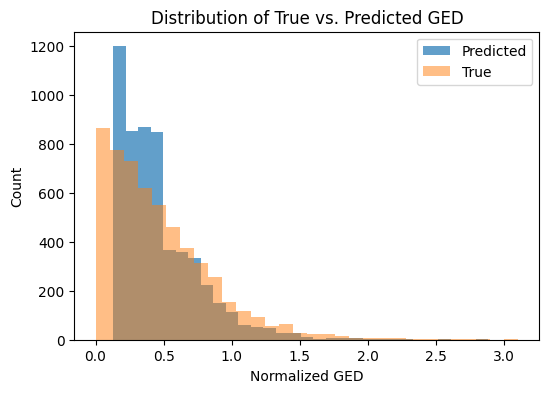

In [13]:
plt.figure(figsize=(6,4))
plt.hist(all_preds, bins=30, alpha=0.7, label="Predicted")
plt.hist(all_labels, bins=30, alpha=0.5, label="True")
plt.legend()
plt.xlabel("Normalized GED")
plt.ylabel("Count")
plt.title("Distribution of True vs. Predicted GED")
plt.show()
